## preset

In [ ]:
#preset1 - 패키지 opt1 - 구글드라이브에 설치하기
import os, sys
from google.colab import drive

#preset1 -  Colab Notebooks 안에 .env 폴더에 패키지 저장 ( 심볼링 링크가 작동 안된다. )
"""
drive.mount('/content/drive')
my_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/_ColabNotebooks/.env', my_path) # 기존 path를 바꿔치기
sys.path.insert(0, my_path)
"""
#preset1 -  Dependency - 위 preinstall 작업을 안하면, 세션 할당시 매번 install
"""
!pip install --target=$my_path finance_datareader
"""

#preset1 - 패키지 opt2 - 매번 설치하기

# !pip install finance_datareader

#preset -  my_data있는 드라이브 마운트
drive.mount('/content/drive')
prefix_path = "/content/drive/My Drive/_ColabNotebooks/"


import pandas as pd
import numpy as np

#preset - 주피터 노트북 여러줄 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#preset - pandas
pd.set_option("display.float_format",lambda x: '%.3f'%x) # 소수점 6자리 > 3자리만 보여달라
pd.set_option("max_columns",None) # 컬럼을 ... 으로 요약하지 마라 ( row는 요약되어있다.)
# pd.DataFrame(np.random.randn(1000,300))

"\ndrive.mount('/content/drive')\nmy_path = '/content/notebooks'\nos.symlink('/content/drive/My Drive/_ColabNotebooks/.env', my_path) # 기존 path를 바꿔치기\nsys.path.insert(0, my_path)\n"

'\n!pip install --target=$my_path finance_datareader\n'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 준비

In [ ]:
df = pd.read_csv(prefix_path+"my_data/naver_finance/2016_12.csv")

In [ ]:
df.head()
# 2016 재무재표 데이터이다. price1,2 = 년초,년말

,ticker,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2
0,AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000
1,BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000
2,BNK금융지주,49126.760,14.499,10.546,5181.144,7.919,0.564,nan,1568.237,20810.660,15358.993,5.535,0.417,0.565,8680.000,9420.000
3,BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000
4,CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000


## 수익률 구하기 (16.12 ~ 17.12)

In [ ]:
df['rtn'] = df['price2'] / df['price'] - 1
df.head()
# 100 -> 110 = 0.1 ( 10프로 증가 )
# 100 -> 90 = -0.1 ( 10프로 감소 )
# 100 -> 1000 = 1 ( 10 배가 올랐구나)
# 100 -> 101  = 0.01 ( 1프로 증가 )

,ticker,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn
0,AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000,0.223
1,BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000,-0.638
2,BNK금융지주,49126.760,14.499,10.546,5181.144,7.919,0.564,nan,1568.237,20810.660,15358.993,5.535,0.417,0.565,8680.000,9420.000,0.085
3,BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000,-0.229
4,CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000,-0.029


# PER 값에 따라 group number 부여하기

## 값을 기준으로 grouping 하기 (DIFFERENT number of members in each  group)

### boolean selection & loc 사용

- 곧 뒤에서 배울 `cut()` 을 사용하면 아래 방법보다 더 쉽게 가능합니다. 하지만 여기서 진행하는 방식들도 매우 중요하니 반드시 익혀두세요!

In [ ]:
# eg) PER을 4개의 boundary로 나눠서
# 각 1등급~3등급, -1등급으로 새로운 컬럼을 PER_Score 라고 만들어 보자.

(df['PER(배)'] >= 10).head()

0     True
1     True
2    False
3     True
4     True
Name: PER(배), dtype: bool

In [ ]:
# PER 을 4단계로 분류를 하였다.
bound1 = df['PER(배)'] >= 10
bound2 = (5 <= df['PER(배)']) & (df['PER(배)'] < 10)
bound3 = (0 <= df['PER(배)']) & (df['PER(배)'] < 5)
bound4 = df['PER(배)'] < 0
# 주의 - 예측 이중에서 nan으로 false인 경우가 있다.

In [ ]:
df.shape

(681, 17)

In [ ]:
df[bound1].shape # = df.loc[bound1].shape

(378, 17)

In [ ]:
# loc을 이용해서 set이 가능 하다.
# bound1 에 1급이라고
# df에서 조작을 할때, 반복문을 돈다면 병렬연산이 안되고 있음을 염두 !

# case1 - 불린 시리즈로 데이터 업데이트 하기
# bound1 불린 조건에 맞으면 PER(배)를 1로 수정한다.
# df.loc[bound1, 'PER(배)'] = 1

# case2 - 불린 시리즈로 데이터 추가 하기 
df.loc[bound1, 'PER_Score'] = 1
df.loc[bound2, 'PER_Score'] = 2
df.loc[bound3, 'PER_Score'] = 3
df.loc[bound4, 'PER_Score'] = -1
df

,ticker,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn,PER_Score
0,AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000,0.223,1.000
1,BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000,-0.638,1.000
2,BNK금융지주,49126.760,14.499,10.546,5181.144,7.919,0.564,nan,1568.237,20810.660,15358.993,5.535,0.417,0.565,8680.000,9420.000,0.085,2.000
3,BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000,-0.229,1.000
4,CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000,-0.029,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,휴비스,11435.011,1.318,0.793,90.698,2.243,1.024,2.022,254.823,11925.160,33144.960,32.218,0.688,0.248,8210.000,10100.000,0.230,1.000
677,휴스틸,3640.215,0.370,-0.153,-5.562,-0.143,-0.101,0.059,-80.399,55779.490,52614.773,-191.546,0.276,0.293,15400.000,15450.000,0.003,-1.000
678,휴켐스,5982.317,12.853,6.670,399.036,8.926,5.468,15.622,1054.733,12782.247,14634.354,20.574,1.698,1.483,21700.000,24550.000,0.131,1.000
679,흥국화재,43359.560,0.362,0.727,315.040,6.337,0.328,nan,483.455,8474.862,66538.880,7.664,0.437,0.056,3705.000,5350.000,0.444,2.000


In [ ]:
df['PER_Score'].head()

0   1.000
1   1.000
2   2.000
3   1.000
4   1.000
Name: PER_Score, dtype: float64

In [ ]:
df['PER_Score'].nunique()

4

In [ ]:
df['PER_Score'].value_counts() # 스코어별 갯수를 구해보자.

1.000     378
2.000     148
-1.000    120
3.000      23
Name: PER_Score, dtype: int64

- `PER_Score`가 float number로 나오는 이유?  
nan 는 float으로 취급하기 때문에  
int를 넣어도 float으로 케스팅 된다. 
*이를 통해 데이터에 nan이 있음을 알 수 있다.

In [ ]:
df['PER_Score'].hasnans # nan check & 

True

In [ ]:
df['PER_Score'].isna().sum() 
# nan이 원천에 존재하고,4개의 bound에 속하지 않는 경우가 생긴다.

12

In [ ]:
df['PER(배)'].isna().sum()

12

In [ ]:
df[df['PER(배)'].isna()] # 이 nan 들 어떻게 해야 할까...

,ticker,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn,PER_Score
27,HSD엔진,8029.166,0.528,-22.571,-1812.265,-32.685,-13.120,2.749,-2607.575,7687.264,11552.757,nan,0.404,nan,2290.000,2569.000,0.122,nan
103,고려개발,6238.648,4.223,-4.895,-305.362,141.454,-4.903,20.462,-3118.716,1988.392,63716.438,nan,6.327,nan,12430.000,11659.000,-0.062,nan
126,까뮤이앤씨,1397.081,3.180,2.331,32.563,6.721,2.390,7.808,72.117,1153.474,3094.153,nan,0.958,nan,1105.000,1010.000,-0.086,nan
133,남영비비안,2074.953,-0.949,-1.103,-22.895,-1.667,-1.371,-2.101,-32.324,2031.729,3021.213,nan,0.436,nan,885.000,777.000,-0.122,nan
203,티탑스,940.880,-7.061,-4.217,-39.673,-8.980,-4.092,nan,-1917.146,19287.736,44614.258,nan,0.058,nan,1115.000,1575.000,0.413,nan
231,롯데칠성음료,22642.120,6.463,3.054,691.439,2.961,1.531,3.109,5107.448,172911.200,166829.270,nan,8.363,nan,145675.000,132900.000,-0.088,nan
371,쌍용양회공업,14302.892,18.027,12.243,1751.111,11.589,5.694,9.037,400.919,3627.562,3319.079,nan,0.816,nan,2960.000,3730.000,0.260,nan
507,컨버즈,459.748,-19.328,-35.526,-163.331,nan,nan,nan,-33811.426,20164.525,95172.870,nan,0.397,nan,4416.000,1750.000,-0.604,nan
560,풀무원,20306.730,1.869,0.491,99.778,6.765,0.979,1.933,4881.663,6986.189,533111.700,nan,2.011,nan,14050.000,17200.000,0.224,nan
622,한일철강,1112.614,5.475,4.236,47.131,3.405,1.467,4.510,249.431,8408.528,5453.988,nan,0.297,nan,2500.000,2645.000,0.058,nan


In [ ]:
df.loc[df['PER_Score'].isna(), "PER_Score"] = 0

# 아래와 같은 방식으로도 가능
# df['PER_Score'] = df['PER_Score'].fillna(0) 
# df.loc[:, 'PER_Score'] = df['PER_Score'].fillna(0)

### boolean series 의 연산 특성 사용

In [ ]:
# eg) PER을 4가지 바운더리로 나누고, 새로운 등급으로 컬럼을 추가해보자
# *단, nan은 0으로 셋팅한다.

(bound1 * 1).head() # bound1 이 참이면 1을 대입한다.

0    1
1    1
2    0
3    1
4    1
Name: PER(배), dtype: int64

In [ ]:
# 각 바운드를 더하게 되면 nan을 0이고, bound1=1,...bound4=-1로 매핑된다. 
((bound1 * 1)  + (bound2 * 2) + (bound3 * 3) + (bound4 * -1)).tail(10)

671    1
672    1
673    1
674    3
675    1
676    1
677   -1
678    1
679    2
680   -1
Name: PER(배), dtype: int64

In [ ]:
df.loc[:, "PER_Score1"] = (bound1 * 1)  + (bound2 * 2) + (bound3 * 3) + (bound4 * -1) 

In [ ]:
df['PER_Score1'].head()

0    1
1    1
2    2
3    1
4    1
Name: PER_Score1, dtype: int64

In [ ]:
df['PER_Score1'].value_counts()

 1    378
 2    148
-1    120
 3     23
 0     12
Name: PER_Score1, dtype: int64

In [ ]:
df['PER_Score'].value_counts()

1.000     378
2.000     148
-1.000    120
3.000      23
0.000      12
Name: PER_Score, dtype: int64

### 위의 두 score series는 서로 같을까? 

In [ ]:
df['PER_Score'].equals(df['PER_Score1']) # 다르다. 

False

In [ ]:
df['PER_Score'].dtypes # nan이 있어서 float로 ~
df['PER_Score1'].dtypes # nan이 0으로 변해서 Int64

dtype('float64')

dtype('int64')

In [ ]:
df['PER_Score'].astype(int).equals(df['PER_Score1'])
# * 새로운 방법이 생각나면 시도해보고 같은지 유닛테스트를 만들어주면 리팩터링때 좋다.   

True

### `cut()`

In [ ]:
per_cuts = pd.cut(
    df['PER(배)'],
    [-np.inf, 0, 5, 10, np.inf], 
)

per_cuts.head() # 시리즈(카테고리-유한개+이산데이터다.) 나온다.

0    (10.0, inf]
1    (10.0, inf]
2    (5.0, 10.0]
3    (10.0, inf]
4    (10.0, inf]
Name: PER(배), dtype: category
Categories (4, interval[float64]): [(-inf, 0.0] < (0.0, 5.0] < (5.0, 10.0] < (10.0, inf]]

In [ ]:
per_cuts.iloc[0] # interval이라는 시리즈가 나온다 .. !

Interval(10.0, inf, closed='right')

In [ ]:
per_cuts.value_counts()

(10.0, inf]    378
(5.0, 10.0]    148
(-inf, 0.0]    120
(0.0, 5.0]      23
Name: PER(배), dtype: int64

In [ ]:
per_cuts.isna().sum() # 역시 nan은 나온다.

12

- cut()과 동시에 label 달아주기

In [ ]:
bins = [-np.inf, 10, 20, np.inf]
labels = ['저평가주', '보통주', '고평가주']
per_cuts2 = pd.cut(
    df['PER(배)'], 
    bins=bins, 
    labels=labels
)
per_cuts2.head()

0     보통주
1    고평가주
2    저평가주
3     보통주
4    고평가주
Name: PER(배), dtype: category
Categories (3, object): ['저평가주' < '보통주' < '고평가주']

In [ ]:
# 결과를 원본에 update하기 - 두 가지 방법
# df.loc[:, 'PER_score2'] = per_cuts  # or per_cuts2
# df['PER_score2'] = per_cuts         # or per_cuts2

## Group내 데이터 갯수를 기준으로 grouping 하기 (SAME number of members in each  group)

### `qcut()`
- 퀀타일 컷
- PER이 정규분포곡선을 따를때 개체수를 기준으로 4등분을 해본다. 등

In [ ]:
# 개체수 기준으로 3등분한다. - 저평가,보통,고평가 
# 그때의 q(퀀타일) 이 출력된다. 
# eg) 0번은 PER이 7.6~16.4로 중간에 속한다.
# Eg) 0~2번 그룹은 len()//3 으로 동일하다. (+- 1 차이는 존재)
pd.qcut(df['PER(배)'], 3).head()

0        (7.666, 16.495]
1     (16.495, 7056.129]
2    (-27857.497, 7.666]
3     (16.495, 7056.129]
4     (16.495, 7056.129]
Name: PER(배), dtype: category
Categories (3, interval[float64]): [(-27857.497, 7.666] < (7.666, 16.495] < (16.495, 7056.129]]

In [ ]:
# 
pd.qcut(df['PER(배)'], 3, labels=[1,2,3]).head()

0    2
1    3
2    1
3    3
4    3
Name: PER(배), dtype: category
Categories (3, int64): [1 < 2 < 3]

In [ ]:
# 개체수기준으로 PER를 10 개로 나누기 
df.loc[:, 'PER_Score2'] = pd.qcut(df['PER(배)'], 10, labels=range(1, 11))
df.head()

,ticker,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn,PER_Score,PER_Score1,PER_Score2
0,AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000,0.223,1.000,1,5
1,BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000,-0.638,1.000,1,8
2,BNK금융지주,49126.760,14.499,10.546,5181.144,7.919,0.564,nan,1568.237,20810.660,15358.993,5.535,0.417,0.565,8680.000,9420.000,0.085,2.000,2,3
3,BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000,-0.229,1.000,1,8
4,CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000,-0.029,1.000,1,9


In [ ]:
df['PER_Score2'].value_counts()

10    67
9     67
8     67
7     67
5     67
4     67
3     67
2     67
1     67
6     66
Name: PER_Score2, dtype: int64

In [ ]:
df['PER_Score2'].hasnans

True

In [ ]:
df['PER_Score2'].isna().sum()
# nan이 존재하면 -1로 매꿀꺼야
# df['PER_Score2'] = df['PER_Score2'].fillna(-1) (애러)
# 카테고리의 데이터안에 속하지 않는 값이다. 1~10으로 카테고리 데이터를 주는것 가능
# Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]


12

In [ ]:
df['PER_Score2'].dtype # 큐컷으로 컬럼을 주니, 카테고리컬 타입이다.

CategoricalDtype(categories=Noneordered=True)

- 'category' type: A string variable consisting of only a few different values

In [ ]:
# DataFrame에서 category dtype인 columns들 추출하기
# df.select_dtypes(include=['category']).columns

In [ ]:
df['PER_Score2'].head() # int형이 아니다. 

0    5
1    8
2    3
3    8
4    9
Name: PER_Score2, dtype: category
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

In [ ]:
df['PER_Score2'].value_counts()

10    67
9     67
8     67
7     67
5     67
4     67
3     67
2     67
1     67
6     66
Name: PER_Score2, dtype: int64

In [ ]:
# nan 처리하는 방법
# 1. 랜덤 값 채우기
# 2. 유사값 채우기 ( sector가 비슷한 종목의 평균 등 )
# 3. dropna 로 없애기
df = df.dropna(subset=['PER(배)'])

In [ ]:
df['PER_Score2'].isna().sum()

0

# Split - Apply - Combine 
- 그룹별로 데이터로 쪼갠다.
- 어떤 함수를 그룹별로 적용을 한다.
- 다시 합친다.

- groupby, aggregation

In [ ]:
df = pd.read_csv(prefix_path+"my_data/naver_finance/2016_12.csv")
df.shape

(681, 16)

In [ ]:
# 72개의 데이터 날려버리고
df = df.dropna()
df.shape

(609, 16)

In [ ]:
# 깊은 복사로 복제. 
g_df = df.copy()
g_df.head()

,ticker,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2
0,AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000
1,BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000
3,BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000
4,CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000
5,CJ CGV,14322.454,4.911,0.393,56.217,3.105,0.284,2.919,583.051,17654.154,67682.260,120.744,3.988,1.040,70400.000,74200.000


## Group score 생성

In [ ]:
g_df['rtn'] = g_df['price2'] / g_df['price'] - 1

In [ ]:
g_df.loc[:, 'PER_score'] = pd.qcut(g_df['PER(배)'], 10, labels=range(1, 11))
g_df.loc[:, 'PBR_score'] = pd.qcut(g_df['PBR(배)'], 10, labels=range(1, 11))

In [ ]:
g_df.set_index('ticker', inplace=True)

In [ ]:
g_df.head()

,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn,PER_score,PBR_score
ticker,,,,,,,,,,,,,,,,,,
AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000,0.223,5,7
BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000,-0.638,8,10
BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000,-0.229,8,5
CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000,-0.029,9,8
CJ CGV,14322.454,4.911,0.393,56.217,3.105,0.284,2.919,583.051,17654.154,67682.260,120.744,3.988,1.040,70400.000,74200.000,0.054,10,10


In [ ]:
# g_df.get_dtype_counts()
g_df.dtypes.value_counts() # instead of 

float64     16
category     2
dtype: int64

## groupby() & aggregation

- `groupby()`
    - 실제로 grouping까지는 하지 않고, grouping이 가능한지 validation만 진행(preparation)
- Aggregation
    - 2가지 요소로 구성
        - aggregating columns
        - aggregating functions
            - e.g. `sum, min, max, mean, count,  

- cf) transform,apply,filter 도 중요!  
(apply함수에 aggregation만 있는게 아님) 

- 결국, 3가지 요소만 충족시키면 됨!
    - Grouping columns (cateogorial data type)
    - Aggregating columns
    - Aggregating functions

### `groupby` object 살펴보기

In [ ]:
g_df.groupby('PER_score') # 1~10까지 묶임
# -> 어떤 오브젝트를 준다. 

In [ ]:
# PBR로 우선 묶고, 그 안에서도 PER 스코어를 본다.
g_df_obj = g_df.groupby(["PBR_score", "PER_score"])
# 1-1,1-2,...10-9,10-10끼리 묶임
g_df_obj

In [ ]:
type(g_df_obj)

pandas.core.groupby.generic.DataFrameGroupBy

In [ ]:
g_df_obj.ngroups # 그룹의 갯수, 그룹핑이 가능함을 확인함

96

In [ ]:
g_df['PBR_score'].nunique() # 10
g_df['PER_score'].nunique() # 10
# 중요!. 각각 그룹핑하면 10개씩 나오는데, 같이그루핑하면 96개가 나온다.
# 의문 10개씩 나온거면 nan은 ?? - 제외하고 count된거라면 
# []

10

10

- "ngroups와 (g_df['PBR_score'].nunique() x g_df['PER_score'].nunique())가 차이가 나는 이유"에 대해서 생각해보기

In [ ]:
type(g_df_obj.size())

pandas.core.series.Series

In [ ]:
g_df_obj.size().head(30)
# 멀티 레벨 인덱스이다. 인덱스에 인덱스
# level=1,level=2 의 인덱스도 라벨이 있다.

PBR_score  PER_score
1          1             5
           2            11
           3            11
           4            11
           5             7
           6             2
           7             4
           8             0
           9             3
           10            7
2          1             6
           2             2
           3            10
           4             9
           5             8
           6             7
           7             5
           8             5
           9             5
           10            4
3          1             0
           2             4
           3            15
           4            10
           5             6
           6             7
           7             7
           8             4
           9             3
           10            5
dtype: int64

In [ ]:
# Multi-level index를 가진 Series indexing하는 법 
g_df_obj.size().loc[1] #  

PER_score
1      5
2     11
3     11
4     11
5      7
6      2
7      4
8      0
9      3
10     7
dtype: int64

In [ ]:
g_df_obj.size().loc[(1, 1)] # 1,1 의 데이터 참조

5

In [ ]:
# Series -> DataFrame으로 변환 (확인용)
g_df_obj.size().to_frame().head(20)

0
PBR_score PER_score    
1         1           5
          2          11
          3          11
          4          11
          5           7
          6           2
          7           4
          8           0
          9           3
          10          7
2         1           6
          2           2
          3          10
          4           9
          5           8
          6           7
          7           5
          8           5
          9           5
          10          4

In [ ]:
# 그룹 바이 객체의 타입,키,벨류스
type(g_df_obj.groups)

pandas.io.formats.printing.PrettyDict

In [ ]:
g_df_obj.groups.keys()

dict_keys([(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 9), (1, 10), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (9, 1), (9, 2), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (10, 1), (10, 2), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10)])

In [ ]:
g_df_obj.groups.values()

dict_values([Index(['E1', 'S&T중공업', '디아이동일', '한국수출포장공업', '휴스틸'], dtype='object', name='ticker'), Index(['LS네트웍스', 'STX', 'STX중공업', '두산건설', '삼부토건', '서연', '전방', '한국가스공사',
       '한국전자홀딩스', '한진중공업', '한진중공업홀딩스'],
      dtype='object', name='ticker'), Index(['KISCO홀딩스', '세아홀딩스', '신대양제지', '아세아', '아세아시멘트', '예스코홀딩스', '지엠비코리아',
       '지역난방공사', '케이비아이동국실업', '한국전력공사', '한국프랜지공업'],
      dtype='object', name='ticker'), Index(['계룡건설산업', '대한화섬', '아세아제지', '인지컨트롤스', '평화홀딩스', '한국공항', '한국제지', '한국철강',
       '한일홀딩스', '한진', '현대제철'],
      dtype='object', name='ticker'), Index(['CS홀딩스', '대성홀딩스', '대한제분', '삼성공조', '삼천리', '성창기업지주', '하이스틸'], dtype='object', name='ticker'), Index(['경동인베스트', '유성기업'], dtype='object', name='ticker'), Index(['서울도시가스', '선창산업', '일신방직', '화천기공'], dtype='object', name='ticker'), Index(['가온전선', '롯데쇼핑', '삼아알미늄'], dtype='object', name='ticker'), Index(['KEC', 'S&T홀딩스', '무림페이퍼', '영흥철강', '유니온', '태광산업', '혜인'], dtype='object', name='ticker'), Index(['GS건설', '대한방직', '무림P&P', '삼성중공업', '신원', '한솔홀딩

In [ ]:
# Retrieve specific group
g_df_obj.get_group((1, 1)) # 해당 그룹의 데이터 프레임이 나온다.

,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn,PER_score,PBR_score
ticker,,,,,,,,,,,,,,,,,,
E1,39959.008,0.277,-0.949,-379.397,-2.350,-1.076,-1.633,-3869.011,191789.690,582492.800,-16.206,0.327,0.108,62700.000,56900.000,-0.093,1,1
S&T중공업,4680.078,-0.309,-5.221,-244.358,-3.671,-2.697,-0.791,-734.851,21043.785,14074.280,-12.369,0.432,0.646,9089.000,7310.000,-0.196,1,1
디아이동일,8224.145,2.100,0.132,10.885,-0.753,0.111,0.051,-1523.407,270773.030,333554.280,-37.365,0.210,0.171,56922.000,51884.000,-0.089,1,1
한국수출포장공업,2282.604,1.344,-0.091,-2.075,-0.092,-0.069,0.152,-51.880,56026.280,57065.100,-345.030,0.319,0.314,17900.000,15650.000,-0.126,1,1
휴스틸,3640.215,0.370,-0.153,-5.562,-0.143,-0.101,0.059,-80.399,55779.490,52614.773,-191.546,0.276,0.293,15400.000,15450.000,0.003,1,1


- For loop을 이용해서 grouping된 object 확인해보기 (많이는 안쓰임)

In [ ]:
# (1,1) 의 group 이라는 데이터 프레임이 있다.
for name, group in g_df_obj:
    print(name)
    group.head(2)
    break

(1, 1)


,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn,PER_score,PBR_score
ticker,,,,,,,,,,,,,,,,,,
E1,39959.008,0.277,-0.949,-379.397,-2.350,-1.076,-1.633,-3869.011,191789.690,582492.800,-16.206,0.327,0.108,62700.000,56900.000,-0.093,1,1
S&T중공업,4680.078,-0.309,-5.221,-244.358,-3.671,-2.697,-0.791,-734.851,21043.785,14074.280,-12.369,0.432,0.646,9089.000,7310.000,-0.196,1,1


In [ ]:
# 참고 :groupby()에 대해 head()를 적용하면, 기존이 head()가 작동하는 방식, 즉, 최상위 2개를 가지고 오는게 아니라
# 각 그룹별 최상위 2개를 *무작위*로 섞어서 하나로 합친 DataFrame을 리턴함
# 그룹바이가 잘 되었는지 check 용
g_df.groupby('PER_score').head(2)

,매출액(억원),영업이익률(%),순이익률(%),당기순이익(억원),ROE(%),ROA(%),ROIC(%),EPS(원),BPS(원),SPS(원),PER(배),PBR(배),PSR(배),price,price2,rtn,PER_score,PBR_score
ticker,,,,,,,,,,,,,,,,,,
AK홀딩스,29218.310,7.313,4.563,1333.223,12.193,5.091,15.515,5436.413,48112.402,220556.160,10.301,1.164,0.254,56000.000,68500.000,0.223,5,7
BGF,860.773,9.315,214.481,1846.192,21.624,10.433,8.015,3703.577,18648.623,1737.263,22.757,4.519,48.514,42140.000,15250.000,-0.638,8,10
BYC,2118.576,7.625,8.281,175.433,4.543,2.463,10.748,20872.312,471887.000,252211.450,19.020,0.841,1.574,397000.000,306000.000,-0.229,8,5
CJ,239541.970,5.230,2.379,5698.234,6.080,2.253,5.158,6257.152,114276.080,672045.900,28.181,1.543,0.262,176334.000,171148.000,-0.029,9,8
CJ CGV,14322.454,4.911,0.393,56.217,3.105,0.284,2.919,583.051,17654.154,67682.260,120.744,3.988,1.040,70400.000,74200.000,0.054,10,10
CJ대한통운,60819.457,3.756,1.122,682.101,2.390,1.361,4.947,2445.658,133105.080,266607.660,73.191,1.345,0.671,179000.000,140000.000,-0.218,10,8
CS홀딩스,1231.450,16.105,13.918,171.388,4.409,5.921,12.719,7994.886,186451.840,106666.850,10.094,0.433,0.757,80700.000,80200.000,-0.006,5,1
DB,2048.100,5.324,-10.113,-207.128,-13.052,-8.434,66.574,-113.728,881.178,1124.549,-6.454,0.833,0.653,734.000,658.000,-0.104,2,5
DB하이텍,7731.402,22.302,11.427,883.440,29.647,8.962,24.540,1984.761,7900.009,17369.578,8.011,2.013,0.915,15900.000,12000.000,-0.245,4,9


### aggreggation

- 반드시 "aggregating" 기능이 있는 function 을 써야함
    - min, max, mean, median, sum, var, size, nunique, idxmax

In [ ]:
# 1. 그룹핑할 컬럼 - PBR 스코어 기준!
# 저평가,보통,고평가로 우선 나눠
# 2. agg 컬럼 - rtn 을 고를래
# 얼마나 올랐는지를 관찰하고 싶어
# 3. agg 함수 - 평균
# 평균을 내보서 관찰하자.
g_df.groupby("PBR_score").agg(
    {
        "rtn": "mean", # =  np.mean
    }
)
# PBR스코어 1인,  저평가 주들은 평균 -0.001 하락
# PBR스코어 10인, 고평가 주들을 평균 +0.054 상승 

,rtn
PBR_score,
1,-0.001
2,0.020
3,-0.021
4,0.161
5,-0.012
6,-0.043
7,0.150
8,0.058
9,0.139


In [ ]:
pbr_rtn_df = g_df.groupby("PBR_score").agg({'rtn': 'mean'})
per_rtn_df = g_df.groupby("PER_score").agg({'rtn': 'mean'})

In [ ]:
pbr_rtn_df.head()

,rtn
PBR_score,
1,-0.001
2,0.020
3,-0.021
4,0.161
5,-0.012


In [ ]:
# 다양한 방법으로 진행하기 (같은 결과)
g_df.groupby("PER_score")['rtn'].agg('mean').head()
g_df.groupby("PER_score")['rtn'].agg(np.mean).head()
g_df.groupby("PER_score")['rtn'].mean().head()

PER_score
1   -0.062
2   -0.083
3   -0.038
4    0.056
5    0.000
Name: rtn, dtype: float64

PER_score
1   -0.062
2   -0.083
3   -0.038
4    0.056
5    0.000
Name: rtn, dtype: float64

PER_score
1   -0.062
2   -0.083
3   -0.038
4    0.056
5    0.000
Name: rtn, dtype: float64

In [ ]:
# return type이 다를 수 있음에 주의
g_df.groupby("PER_score")['rtn'].agg("mean").head(2)   # Series로 return
g_df.groupby("PER_score")[['rtn']].agg("mean").head(2)  # DataFrame으로 return

PER_score
1   -0.062
2   -0.083
Name: rtn, dtype: float64

,rtn
PER_score,
1,-0.062
2,-0.083


In [ ]:
# 2개 이상의 컬럼에 대해 aggregation
g_df.groupby("PER_score")[['rtn', 'PBR(배)']].agg("mean").head(2)

,rtn,PBR(배)
PER_score,,
1,-0.062,1.839
2,-0.083,1.323


In [ ]:
# 2개 이상의 aggregation
g_df.groupby("PER_score")[['rtn', 'PBR(배)']].agg(["mean", "std"]).head(2)

rtn       PBR(배)      
            mean   std   mean   std
PER_score                          
1         -0.062 0.328  1.839 2.215
2         -0.083 0.781  1.323 1.167

In [ ]:
# agg는 dict 형태를 주는것이 좋다.(제일 일반적으로 적용 가능)
# 2개 이상의 컬럼 & 각각에 대해 다른 aggregation
g_df.groupby("PBR_score").agg(
    {
        'rtn': ['mean', 'std'],
        'PER(배)': ['min']
        
    }
)
# rtn는 평균과 std를 구하고 싶고, PER은 최소값을 구하고 싶다.

rtn           PER(배)
            mean   std        min
PBR_score                        
1         -0.001 0.262   -345.030
2          0.020 0.280   -319.356
3         -0.021 0.219    -10.614
4          0.161 0.770   -938.983
5         -0.012 0.265    -62.397
6         -0.043 0.251   -310.606
7          0.150 0.704   -107.741
8          0.058 0.472 -27857.496
9          0.139 0.669   -352.735
10         0.054 0.464   -442.464

- aggregation function이 아닌경우 => `agg()`가 error를 발생시킴


In [ ]:
# sqrt는 aggregation 방식의 연산이 아님!
np.sqrt([1, 2, 3, 4])

array([1.        , 1.41421356, 1.73205081, 2.        ])

In [ ]:
# redux되는 ? 함수만 가능
# g_df.groupby("PER_score")['rtn'].agg(np.sqrt) 애러!


- Visualization(시각화) 맛보기

In [ ]:
# 바로 그래프가 안 보실시
%matplotlib inline

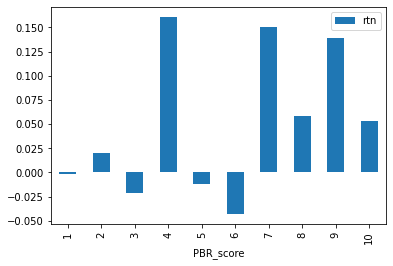

In [ ]:
pbr_rtn_df.plot(kind='bar')

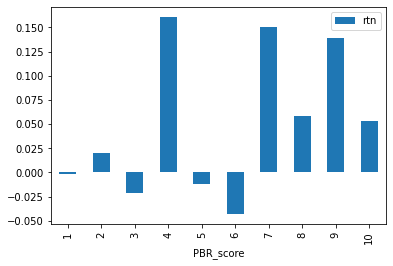

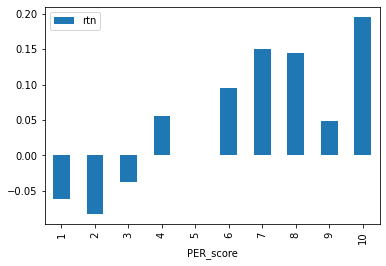

In [ ]:
pbr_rtn_df.plot(kind='bar');
per_rtn_df.plot(kind='bar');
# 규칙성을 관찰 - PER에선 rtn에 대한 규칙성이 보인다.

### Examples

In [ ]:
# \ 을 이용해서 줄을 나누고, 함수가 끝남을 표현
# .에 대해 indent를 맞춘다.
g_df1 = g_df.groupby(["PBR_score", "PER_score"])\
            .agg(
                {
                    'rtn': ['mean', 'std', 'min', 'max'],
                    'ROE(%)': [np.mean, 'size', 'nunique', 'idxmax'] 
                 }
            )
g_df1.head()
# nunique : 얼마나 다양한 ROE가 있나
# idxmax ROE 가 가장 큰 종목의 인덱스

rtn                     ROE(%)                       
                      mean   std    min   max    mean size nunique    idxmax
PBR_score PER_score                                                         
1         1         -0.100 0.072 -0.196 0.003  -1.402    5       5  한국수출포장공업
          2         -0.093 0.266 -0.482 0.437 154.967   11      11      삼부토건
          3          0.117 0.359 -0.556 0.683   6.952   11      11    한국전력공사
          4          0.106 0.295 -0.273 0.882   5.104   11      11      한국공항
          5         -0.039 0.120 -0.206 0.113   3.941    7       7    성창기업지주

In [ ]:
a = g_df.groupby(["PBR_score", "PER_score"])['rtn', 'ROE(%)'].agg(['sum', 'mean'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
# Multi-index라고 해서 쫄 것 없음!
a.loc[1]
a.loc[(1, 3)]
a.loc[[(1, 3), (1, 4 )]]

rtn          ROE(%)        
             sum   mean      sum    mean
PER_score                               
1         -0.499 -0.100   -7.009  -1.402
2         -1.025 -0.093 1704.634 154.967
3          1.290  0.117   76.477   6.952
4          1.165  0.106   56.146   5.104
5         -0.275 -0.039   27.590   3.941
6         -0.666 -0.333    6.710   3.355
7         -0.126 -0.031   11.435   2.859
8            nan    nan      nan     nan
9         -0.175 -0.058    3.039   1.013
10         0.226  0.032    2.873   0.410

rtn     sum     1.290
        mean    0.117
ROE(%)  sum    76.477
        mean    6.952
Name: (1, 3), dtype: float64

rtn       ROE(%)      
                      sum  mean    sum  mean
PBR_score PER_score                         
1         3         1.290 0.117 76.477 6.952
          4         1.165 0.106 56.146 5.104

### 주의: nan은 groupby시 자동으로 filter out 되기 때문에, 미리 전처리 다 하는게 좋음 

In [ ]:
df = pd.DataFrame({
    'a':['소형주', np.nan, '대형주', '대형주'],
    'b':[np.nan, 2,         3,     np.nan],
})
df
# a컬럼은 카테고리컬 데이터 타입에, nan이 있을때 시뮬레이션
# b컬럼은 정수형 데이터 타입일때 가정

,a,b
0,소형주,nan
1,NaN,2.000
2,대형주,3.000
3,대형주,nan


In [ ]:
df.groupby(['a'])['b'].mean()

# 1. operation에서 제거되는 case
# 1. nan이 평균 집계에 아예 빠져버린다. (count에도 안들어간다.)

# 2. 전부 nan인 case
# 2. nan으로 또 표현을 해주어서 이상을 나타냄 

a
대형주   3.000
소형주     nan
Name: b, dtype: float64

###  `as_index = False` : group cols들이 index가 아니라 하나의 col이 됨 (aggregate하고 reset_index()를 취한 것)

In [ ]:
a = g_df.groupby(["PER_score"]                ).agg({'rtn': ['mean', 'std']}).head(2)
b = g_df.groupby(["PER_score"], as_index=False).agg({'rtn': ['mean', 'std']}).head(2)

In [ ]:
a
b
# 그룹 인덱스가 컬럼으로 들어오게 된다. 하지만 멀티레벨인덱스라서 최상위에 위치하게 된다.

rtn      
            mean   std
PER_score             
1         -0.062 0.328
2         -0.083 0.781

PER_score    rtn      
              mean   std
0         1 -0.062 0.328
1         2 -0.083 0.781

In [ ]:
a.reset_index() # b와 같은 결과가 나온다.
# a에 장착된 인덱스를 분리해서 컬럼을 넣음

PER_score    rtn      
              mean   std
0         1 -0.062 0.328
1         2 -0.083 0.781

In [ ]:
# a인덱스는 카테고리컬, b는 int
# a,b 둘다 멀티레벨 컬럼이지만 형태가 다름.
a.index

CategoricalIndex([1, 2], categories=[1, 2, 3, 4, 5, 6, 7, 8, ...], ordered=True, name='PER_score', dtype='category')

In [ ]:
a.columns

MultiIndex([('rtn', 'mean'),
            ('rtn',  'std')],
           )

In [ ]:
b.index

Int64Index([0, 1], dtype='int64')

In [ ]:
b.columns

MultiIndex([('PER_score',     ''),
            (      'rtn', 'mean'),
            (      'rtn',  'std')],
           )

In [ ]:
a['rtn']

,mean,std
PER_score,,
1,-0.062,0.328
2,-0.083,0.781


In [ ]:
a[('rtn', 'mean')].head()

PER_score
1   -0.062
2   -0.083
Name: (rtn, mean), dtype: float64

### Multi-index columns을 하나로 병합하기

In [ ]:
g_df1.head()
# rtn의 mean,std... 의 멀티 레벨 컬럼에서
# rnt_mean, rtn_std .. 의 싱글레벨로 변경

rtn                     ROE(%)                       
                      mean   std    min   max    mean size nunique    idxmax
PBR_score PER_score                                                         
1         1         -0.100 0.072 -0.196 0.003  -1.402    5       5  한국수출포장공업
          2         -0.093 0.266 -0.482 0.437 154.967   11      11      삼부토건
          3          0.117 0.359 -0.556 0.683   6.952   11      11    한국전력공사
          4          0.106 0.295 -0.273 0.882   5.104   11      11      한국공항
          5         -0.039 0.120 -0.206 0.113   3.941    7       7    성창기업지주

In [ ]:
# 컬럼의 레벨을 가져온다ㅏ.
level0 = g_df1.columns.get_level_values(0)
level1 = g_df1.columns.get_level_values(1)

level0 
level1
# Index(['rtn', 'rtn', 'rtn', 'rtn', 'ROE(%)', 'ROE(%)', 'ROE(%)', 'ROE(%)'], dtype='object')
# Index(['mean', 'std', 'min', 'max', 'mean', 'size', 'nunique', 'idxmax'], dtype='object')


Index(['rtn', 'rtn', 'rtn', 'rtn', 'ROE(%)', 'ROE(%)', 'ROE(%)', 'ROE(%)'], dtype='object')

Index(['mean', 'std', 'min', 'max', 'mean', 'size', 'nunique', 'idxmax'], dtype='object')

In [ ]:
g_df1.columns = level0 + '_' + level1

In [ ]:
g_df1.head(2)

rtn_mean  rtn_std  rtn_min  rtn_max  ROE(%)_mean  \
PBR_score PER_score                                                     
1         1            -0.100    0.072   -0.196    0.003       -1.402   
          2            -0.093    0.266   -0.482    0.437      154.967   

                     ROE(%)_size  ROE(%)_nunique ROE(%)_idxmax  
PBR_score PER_score                                             
1         1                    5               5      한국수출포장공업  
          2                   11              11          삼부토건

In [ ]:
# 인덱스도 reset을 한다.
g_df1 = g_df1.reset_index()
g_df1.head()
# 의의 : 새로운 형태의 데이터 프레임을 뽑아냈다. >CSV저장 하는 등
# 계속해서 데이터의 데이터의 데이터를 추출하면서 시각이 생길 수 있다.

,PBR_score,PER_score,rtn_mean,rtn_std,rtn_min,rtn_max,ROE(%)_mean,ROE(%)_size,ROE(%)_nunique,ROE(%)_idxmax
0,1,1,-0.100,0.072,-0.196,0.003,-1.402,5,5,한국수출포장공업
1,1,2,-0.093,0.266,-0.482,0.437,154.967,11,11,삼부토건
2,1,3,0.117,0.359,-0.556,0.683,6.952,11,11,한국전력공사
3,1,4,0.106,0.295,-0.273,0.882,5.104,11,11,한국공항
4,1,5,-0.039,0.120,-0.206,0.113,3.941,7,7,성창기업지주


# 실전예제: 시가총액으로 Small and Big 나누기 

In [ ]:
# eg)
# 시가총액의 중간값을 기준으로 작은 종목은 small,큰 종목은 big이라고 표기하기
# 데이터가 data별로 종목-시총 이렇게 구성되어있다.
# *aggregated된 데이터는 기존 데이터 보다 작다. 
a_df = pd.read_csv(prefix_path+"my_data/Small_and_Big.csv", index_col=[0])
a_df.head()

,date,종목명,PBR(IFRS-연결),"베타 (M,5Yr)",수익률(%),시가총액 (보통)(평균)(원)
0,2000-07-31,BYC,0.210,0.479,-0.580,27786000000.000
1,2000-07-31,CJ,0.510,1.166,-9.000,1160889000000.000
2,2000-07-31,CJ ENM,6.560,nan,17.400,400467000000.000
3,2000-07-31,CJ대한통운,0.170,1.314,-7.960,194962000000.000
4,2000-07-31,CJ씨푸드,nan,0.227,32.000,1987000000.000


In [ ]:
a_df.tail()

,date,종목명,PBR(IFRS-연결),"베타 (M,5Yr)",수익률(%),시가총액 (보통)(평균)(원)
235924,2018-06-30,흥국에프엔비,0.950,1.364,-1.690,64926000000.000
235925,2018-06-30,흥국화재,0.650,0.721,8.890,383175000000.000
235926,2018-06-30,흥아해운,0.920,1.240,-5.750,134473000000.000
235927,2018-06-30,희림,1.390,0.216,2.230,86250000000.000
235928,2018-06-30,힘스,1.420,nan,-15.820,82748000000.000


In [ ]:
median_df = a_df.groupby(['date']).agg({'시가총액 (보통)(평균)(원)': 'median'})
median_df.head()

,시가총액 (보통)(평균)(원)
date,
2000-07-31,34947000000.000
2000-08-31,33684000000.000
2000-09-30,33684000000.000
2000-10-31,30523000000.000
2000-11-30,30798000000.000


In [ ]:
median_df.columns = ['시가총액_median']
median_df.head()

,시가총액_median
date,
2000-07-31,34947000000.000
2000-08-31,33684000000.000
2000-09-30,33684000000.000
2000-10-31,30523000000.000
2000-11-30,30798000000.000


- 구한 median dataframe을 어떻게 가존의 원본 dataframe과 연결 시킬수있을까?
=> 다음 노트북!

In [ ]:
# 1. for loop 를 돈다.
# 2.index 를 date로 매핑하고
# - 각 date에 맞게 시총 median을 주고
# - 대소비교를 통해서값을 추가해준다.
# 3. join해버려